In [1]:
import cv2
import imghdr
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
labels = ['glioma','notumor','meningioma','pituitary']
for i in labels:
    folderPath = os.path.join('E:/anamika_maam/brain/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('E:/anamika_maam/brain/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
        


In [3]:
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train,random_state=101)
X_train.shape

(7022, 224, 224, 3)

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.3,random_state=45)

In [5]:

train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)
train.fit(X_train)



In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [7]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
from tensorflow.keras.layers import *

vgg16_model=tf.keras.applications.VGG19(include_top=False,weights="imagenet",input_tensor=None,input_shape=(224, 224, 3))

for l in vgg16_model.layers:
# Freezing the model
  l.trainable = False

80150528/80134624 [==============================] - 46s 1us/step


In [9]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
from tensorflow.keras.models import *
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(vgg16_model)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) 


In [12]:
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(lr=3e-5) ,metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,236,292
Trainable params: 3,211,908
N

C:\Users\Umesh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = model.fit(train.flow(X_train, y_train, batch_size=64,
         subset='training'),validation_data=train.flow(X_train, y_train,
         batch_size=16, subset='validation'), epochs=50,  callbacks=[tensorboard_callback])


Epoch 1/50
62/62 [==============================] - 51s 578ms/step - loss: 0.9919 - accuracy: 0.5821 - val_loss: 0.5992 - val_accuracy: 0.7843
Epoch 2/50
62/62 [==============================] - 31s 492ms/step - loss: 0.6114 - accuracy: 0.7726 - val_loss: 0.4688 - val_accuracy: 0.8199
Epoch 3/50
62/62 [==============================] - 31s 495ms/step - loss: 0.5103 - accuracy: 0.7968 - val_loss: 0.4143 - val_accuracy: 0.8474
Epoch 4/50
62/62 [==============================] - 31s 499ms/step - loss: 0.4351 - accuracy: 0.8375 - val_loss: 0.3344 - val_accuracy: 0.8830
Epoch 5/50
62/62 [==============================] - 30s 480ms/step - loss: 0.3813 - accuracy: 0.8596 - val_loss: 0.3081 - val_accuracy: 0.8779
Epoch 6/50
62/62 [==============================] - 29s 476ms/step - loss: 0.3492 - accuracy: 0.8741 - val_loss: 0.2876 - val_accuracy: 0.8983
Epoch 7/50
62/62 [==============================] - 29s 472ms/step - loss: 0.3302 - accuracy: 0.8820 - val_loss: 0.2696 - val_accuracy: 0.8973

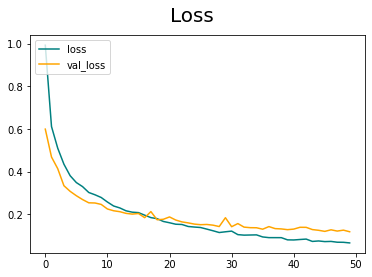

In [14]:
# Plot the loss  curves for training and validation 
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

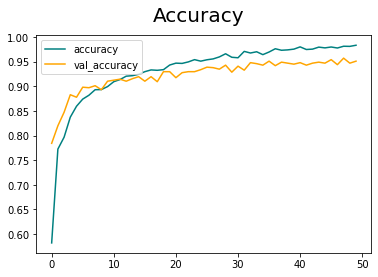

In [15]:
# Plot the loss  accuracy for training and validation 
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [16]:
#model.save(os.path.join('models','vgg16_model.h5'))

In [8]:
from tensorflow.keras.models import load_model
vgg16_model = load_model('models/vgg16_model.h5')

In [9]:
X_test = X_test/255

score_cnn = vgg16_model.evaluate(X_test,y_test)

print('Test loss:', score_cnn[0]) 
print('Test accuracy:', score_cnn[1])

66/66 [==============================] - 21s 243ms/step - loss: 0.1478 - accuracy: 0.9502
Test loss: 0.14775706827640533
Test accuracy: 0.9501661062240601


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.cm as cm

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (12, 12), fontsize=14):
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix.flatten() / np.sum(confusion_matrix)]

    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(class_names), len(class_names))

    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')

    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

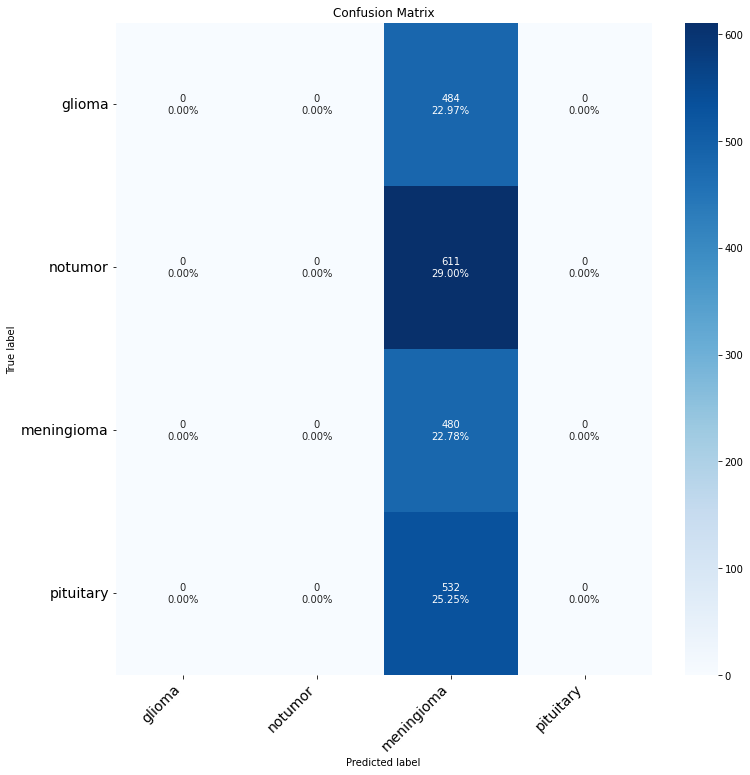

In [16]:
pred = vgg16_model.predict(X_test)
y_test = y_test.argmax(axis=1)

# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
pred_ids = pred.argmax(axis=1)
conf_mat = confusion_matrix(y_test, pred_ids)
figure = print_confusion_matrix(conf_mat, labels)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import sklearn.metrics as skm
print("accuracy=",skm.balanced_accuracy_score(y_test, pred_ids))
print("recall/senstivity=",skm.recall_score(y_test, pred_ids,average='weighted'))
print("precision=",skm.precision_score(y_test, pred_ids,average='weighted'))
print("f1_score=",skm.f1_score(y_test, pred_ids,average='weighted'))